In [81]:
import pandas as pd
import multiprocessing as mp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pydotplus
import math

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz

In [2]:
businessData = pd.read_json("yelp_dataset/business.json", lines=True)
print(f'Size of the data before preprocessing: {businessData.shape}')
# Drop unuseful columns
irrelevantColumns=['address', 'city', 'hours', 'is_open', 'latitude', 'longitude', 'postal_code', 'state']
businessData.drop(columns = irrelevantColumns, inplace=True)
print(f'Size of the data after dropping irrerelevant columns: {businessData.shape}')
businessData.dropna(inplace=True)
print(f'Size of the data after dropping rows that have NA: {businessData.shape}')
businessData.reset_index(drop=True, inplace=True)
businessData.head()

Size of the data before preprocessing: (192609, 14)
Size of the data after dropping irrerelevant columns: (192609, 6)
Size of the data after dropping rows that have NA: (163773, 6)


,attributes,business_id,categories,name,review_count,stars
0,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Arizona Biltmore Golf Club,5,3.0
1,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Emerald Chinese Restaurant,128,2.5
2,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Musashi Japanese Restaurant,170,4.0
3,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Queen City Plumbing,4,4.0
4,"{'BusinessParking': '{'garage': False, 'street...",68dUKd8_8liJ7in4aWOSEA,"Shipping Centers, Couriers & Delivery Services...",The UPS Store,3,2.5


In [3]:
numPartitions = 20
numCores = mp.cpu_count()

def poolExecutor(df, func):
    dfSplit = np.array_split(df, numPartitions)
    pool = mp.Pool(numCores)
    df = pd.concat(pool.map(func, dfSplit))
    pool.close()
    pool.join()
    df.reset_index(drop=True, inplace=True)
    return df

def filterRestaurantData(data):
    data.reset_index(drop=True, inplace=True)
    for i in range(len(data)):
        if "Restaurant" not in data.loc[i,"categories"]:
            data.drop(i, inplace=True)
    return data
        
restaurantData = poolExecutor(businessData, filterRestaurantData)
print(f'Size of the Restaurant data: {restaurantData.shape}')
restaurantData.head()

Size of the Restaurant data: (57176, 6)


,attributes,business_id,categories,name,review_count,stars
0,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Emerald Chinese Restaurant,128,2.5
1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Musashi Japanese Restaurant,170,4.0
2,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...",1Dfx3zM-rW4n-31KeC8sJg,"Restaurants, Breakfast & Brunch, Mexican, Taco...",Taco Bell,18,3.0
3,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...",fweCYi8FmbJXHCqLnwuk8w,"Italian, Restaurants, Pizza, Chicken Wings",Marco's Pizza,16,4.0
4,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...",PZ-LZzSlhSe9utkQYU8pFg,"Restaurants, Italian",Carluccio's Tivoli Gardens,40,4.0


In [4]:
# check for duplicated business id
print(restaurantData.business_id.duplicated().sum())

0


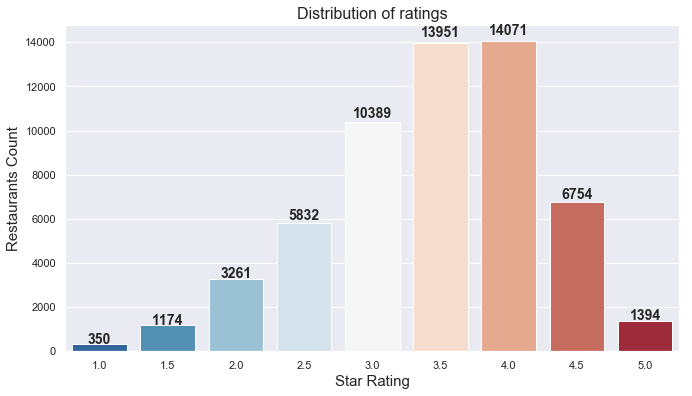

In [5]:
# Distribution of stars
plt.figure(figsize=(11, 6))
starCounts = restaurantData['stars'].value_counts().sort_index()
sns.set(color_codes=True)
sns.barplot(starCounts.index, starCounts.values, palette=sns.color_palette("RdBu_r", len(starCounts)))
for  i, v in enumerate(starCounts):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
plt.xlabel('Star Rating', fontsize=15)
plt.ylabel('Restaurants Count', fontsize=15)
plt.title('Distribution of ratings', fontsize=16)
plt.show()

In [6]:
attributeList = []
flatten = lambda l: [item for sublist in l for item in sublist]

def attrCollector(df, func):
    global attributeList
    dfSplit = np.array_split(df, numPartitions)
    pool = mp.Pool(numCores)
    attributeList.extend(flatten(pool.map(func, dfSplit)))
    attributeList = list(dict.fromkeys(attributeList))
    pool.close()
    pool.join()

def extractAttributes(data):
    attrList = []
    data.reset_index(drop=True, inplace=True)
    for i in range(len(data)):
        for k, v in data['attributes'][i].items():
            v = eval(v)
            if type(v) is dict:
                for k1, v1 in v.items():
                    attrList.append(k1)
            else:
                attrList.append(k)
    return list(dict.fromkeys(attrList))

attrCollector(restaurantData, extractAttributes)
attributeList.sort(key=lambda x: x.lower())
print(len(attributeList))
print(attributeList)

87
['AcceptsInsurance', 'africanamerican', 'AgesAllowed', 'Alcohol', 'Ambience', 'asian', 'background_music', 'BestNights', 'BikeParking', 'breakfast', 'brunch', 'BusinessAcceptsBitcoin', 'BusinessAcceptsCreditCards', 'BusinessParking', 'ByAppointmentOnly', 'BYOB', 'BYOBCorkage', 'casual', 'Caters', 'classy', 'CoatCheck', 'coloring', 'Corkage', 'curly', 'dairy-free', 'dessert', 'DietaryRestrictions', 'dinner', 'divey', 'dj', 'DogsAllowed', 'DriveThru', 'extensions', 'friday', 'garage', 'gluten-free', 'GoodForDancing', 'GoodForKids', 'GoodForMeal', 'halal', 'HappyHour', 'HasTV', 'hipster', 'intimate', 'jukebox', 'karaoke', 'kids', 'kosher', 'latenight', 'live', 'lot', 'lunch', 'monday', 'Music', 'no_music', 'NoiseLevel', 'Open24Hours', 'OutdoorSeating', 'perms', 'RestaurantsAttire', 'RestaurantsCounterService', 'RestaurantsDelivery', 'RestaurantsGoodForGroups', 'RestaurantsPriceRange2', 'RestaurantsReservations', 'RestaurantsTableService', 'RestaurantsTakeOut', 'romantic', 'saturday', '

In [86]:
def buildColumn(attribute):
    col = []
    for i in range(len(restaurantData)):
        found = 0
        for k, v in restaurantData['attributes'][i].items():
            if k == attribute:
                col.append(0 if (v == 'False') else 1)
                found = 1
                break
            v = eval(v)
            if type(v) is dict:
                for k1, v1 in v.items():
                    if k1 == attribute:
                        col.append(0 if (v1 == False) else 1)
                        found = 1
                        break
            if found == 1:
                break
        if found == 0:
            col.append(0)
    return col

columns = []
for i in range(len(attributeList)):
    columns.append(buildColumn(attributeList[i]))

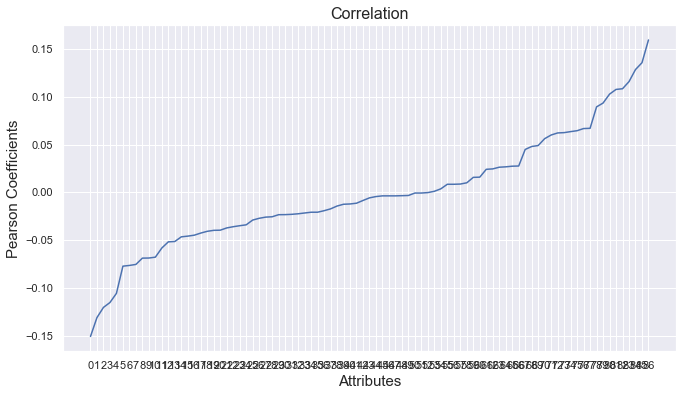

latenight                -0.150885
BusinessAcceptsBitcoin   -0.131106
dessert                  -0.120459
breakfast                -0.115360
validated                -0.105771
WiFi                      0.102714
casual                    0.107643
BikeParking               0.108364
BusinessParking           0.115829
Caters                    0.128440
WheelchairAccessible      0.135598
GoodForMeal               0.159411
dtype: float64


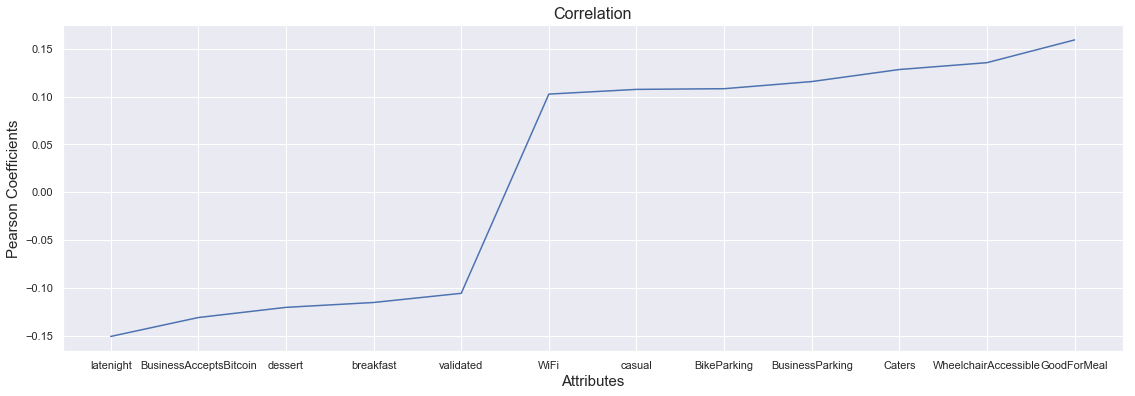

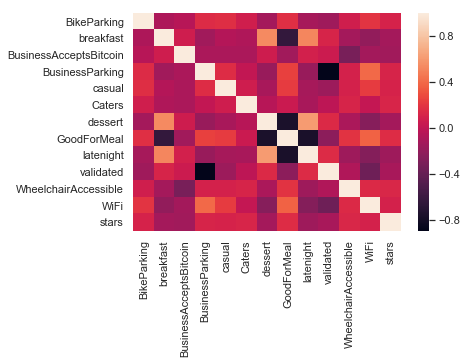

In [161]:
df = pd.DataFrame(columns)
X = df.T
X.columns = attributeList
corrCoeff = X.corrwith(restaurantData['stars'])
corrCoeff.sort_values(inplace=True)
plt.figure(figsize=(11, 6))
plt.xlabel('Attributes', fontsize=15)
plt.ylabel('Pearson Coefficients', fontsize=15)
plt.title('Correlation', fontsize=16)
plt.xticks(range(0, len(corrCoeff), 1))
plt.yticks(np.arange(-0.25, 0.25, 0.05))
plt.plot(range(0, len(corrCoeff)), pd.Series(corrCoeff).values)
plt.show()
dropList = []
values = pd.Series(corrCoeff).values
index = pd.Series(corrCoeff).index
for i in range(len(values)):
    if (math.isnan(values[i]) == True) or (abs(values[i]) <= 0.1):
        dropList.append(index[i])
corrCoeff.drop(index=dropList, inplace=True)
corrCoeff.sort_values(inplace=True)
print(corrCoeff)
plt.figure(figsize=(19, 6))
plt.xlabel('Attributes', fontsize=15)
plt.ylabel('Pearson Coefficients', fontsize=15)
plt.title('Correlation', fontsize=16)
plt.yticks(np.arange(-0.25, 0.25, 0.05))
plt.plot(pd.Series(corrCoeff).index, pd.Series(corrCoeff).values)
plt.show()
X.drop(columns=dropList, inplace=True)
X['stars'] = restaurantData['stars']
sns.heatmap(X.corr())
X.drop(columns = ['stars'], inplace=True)

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, restaurantData['stars'])
print(X_train.shape)
print(X_test.shape)

(42882, 31)
(14294, 31)


In [139]:
def roundOff(num):
    rating = 0
    if (num <=1.25):
        rating = 1.0
    elif (num <= 1.75):
        rating = 1.5
    elif (num <= 2.25):
        rating = 2.0
    elif (num <= 2.75):
        rating = 2.5
    elif (num <= 3.25):
        rating = 3.0
    elif (num <= 3.75):
        rating = 3.5
    elif (num <= 4.25):
        rating = 4.0
    elif (num <= 4.75):
        rating = 4.5
    else:
        rating = 5.0
    return rating

In [143]:
lr = LinearRegression()
reg = lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
#y_pred_train = [roundOff(pred) for pred in y_pred_train]
print('Train RMSE:')
print(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

y_pred_test = lr.predict(X_test)
print('Test RMSE:')
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

Train RMSE:
0.7536185825826339
Test RMSE:
0.7584444243717535


RMSE:
0.7668913147745504


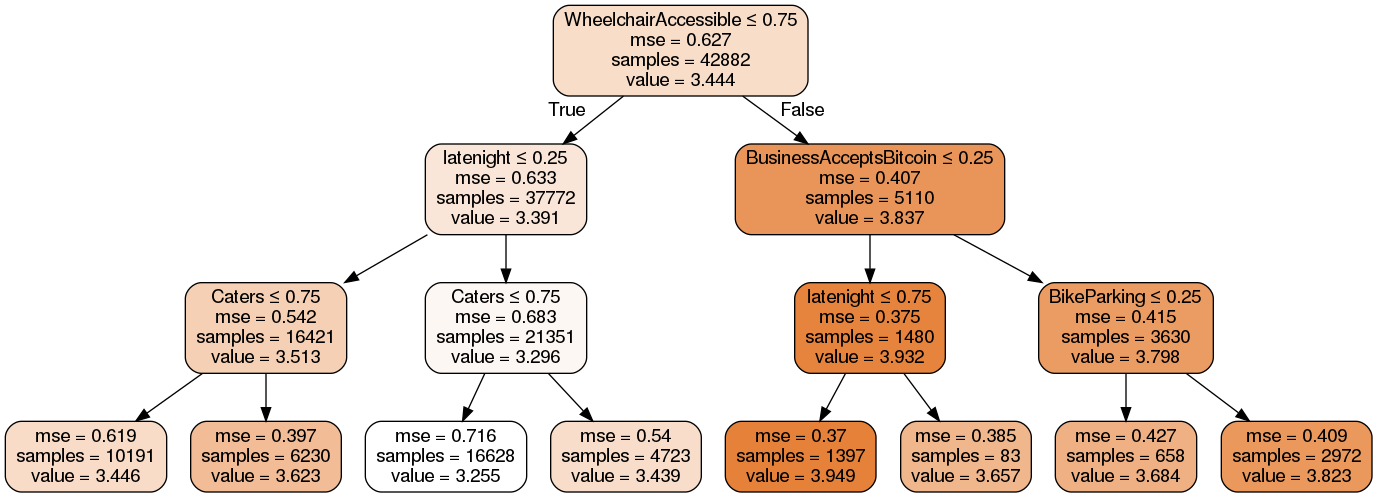

In [164]:
rg_X_train, rg_X_test, rg_y_train, rg_y_test = train_test_split(X, restaurantData['stars'])

rg = DecisionTreeRegressor(max_depth=3)
rg.fit(rg_X_train, rg_y_train)
print('RMSE:')
print(np.sqrt(metrics.mean_squared_error(rg_y_test, rg.predict(rg_X_test))))

# visualize the tree
dot_data = StringIO()  
export_graphviz(rg, out_file=dot_data,  
                    feature_names=X.columns,  
                    filled=True, rounded=True,  
                    special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())